In [4]:
import os
import math

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import sklearn.gaussian_process as gp
from mpl_toolkits.mplot3d import Axes3D

##############################################################################

def filterinitialset (filename, headername = "vibrational level v\Temperature(K)",  \
    factor = 1.0, normalize = False):

    dfin = pd.read_excel(filename)

    #print(dfin)
    
    dfdict = {}
    
    tempvalues = list(dfin.columns[1:])
    vibvalues = list(dfin[headername].values)

    min = float("inf")
    max = float("-inf")
    for c in dfin.columns:
        dfdict[c] = []
        if c == headername:
            dfdict[c] = list(dfin[c].values)
        else:
            for v in dfin[c].values:
                val = factor*v
                if val > max:
                    max = val
                if val < min:
                    min = val

    for c in dfin.columns:
        if c != headername:
            for v in dfin[c].values:
                val = factor*v
                valp = (val - min) / (max - min)
                if normalize:
                    dfdict[c].append(valp)
                else:
                    dfdict[c].append(val)

    df = pd.DataFrame.from_dict(dfdict)

    return df, vibvalues, tempvalues

##############################################################################

def plotfull3dcurve (df, vib_values, temp_values):

    y = []
    x = []
    for t in temp_values:
        for idx in range(len(vib_values)):
            x.append([float(t), float(vib_values[idx])])
            y.append(df[t].values[idx])

    X = np.array(x)
    Y = np.array(y)

    xdim = len(temp_values)
    ydim = len(vib_values)

    Xp = np.zeros((xdim, ydim), dtype=float)
    Yp = np.zeros((xdim, ydim), dtype=float)
    Zp = np.zeros((xdim, ydim), dtype=float)
    for xidx in range(xdim):
        t = temp_values[xidx]
        for yidx in range(ydim):
            v =  vib_values[yidx]
            Xp[xidx, yidx] = float(t)
            Yp[xidx, yidx] = float(v)
            Zp[xidx, yidx] = df[t].values[yidx]

    #fig = plt.figure(figsize=(10,8))
    fig = plt.figure(figsize=plt.figaspect(2.))
    plt.gcf().set_size_inches(40, 30)
    ax = fig.add_subplot(2,1,1, projection='3d')
    surf = ax.plot_surface(Xp, Yp, Zp, rstride=1, cstride=1, cmap='jet', linewidth=0, antialiased=False)
    plt.show()

##########################################################################################################3

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


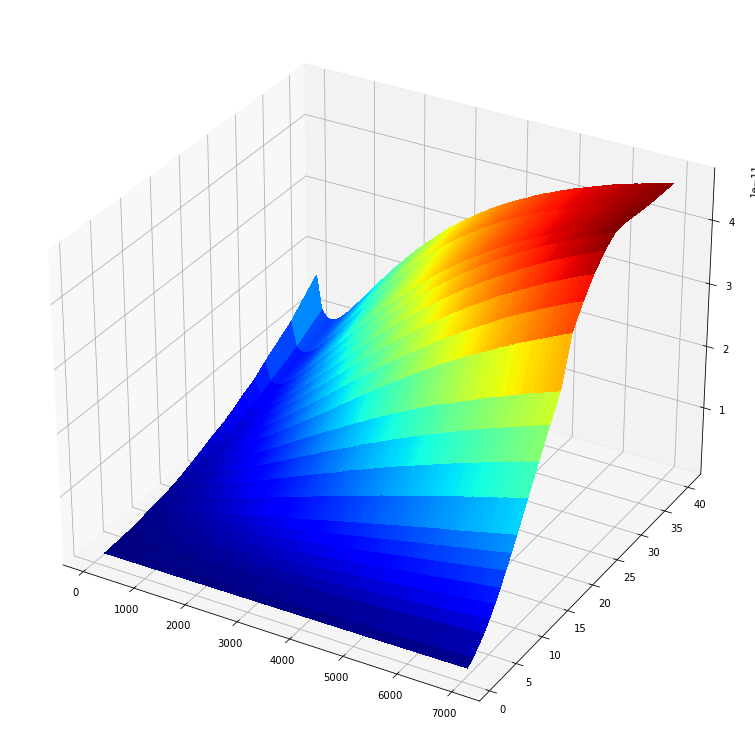

In [5]:
filename = "N2N2_dataset.xls"
df, vib_values , temp_values = filterinitialset (filename)
plotfull3dcurve (df, vib_values, temp_values)

In [27]:
def fitusingscikitl (in_train_x, in_train_y, minx, maxx):

    kernel = gp.kernels.ConstantKernel(1.0, (1e-5, 1e5))* gp.kernels.RBF(length_scale=1)
    model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50, \
        normalize_y=False)
    #print("Start training ")
    #model = RandomForestRegressor()
    model.fit(in_train_x, in_train_y)
    #print("Done ")

    return model

<Figure size 432x288 with 0 Axes>

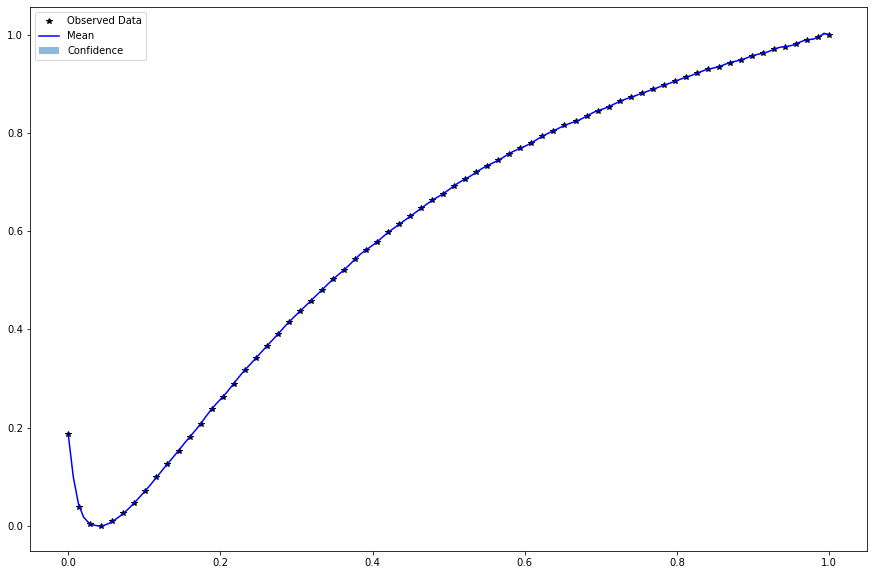

<Figure size 432x288 with 0 Axes>

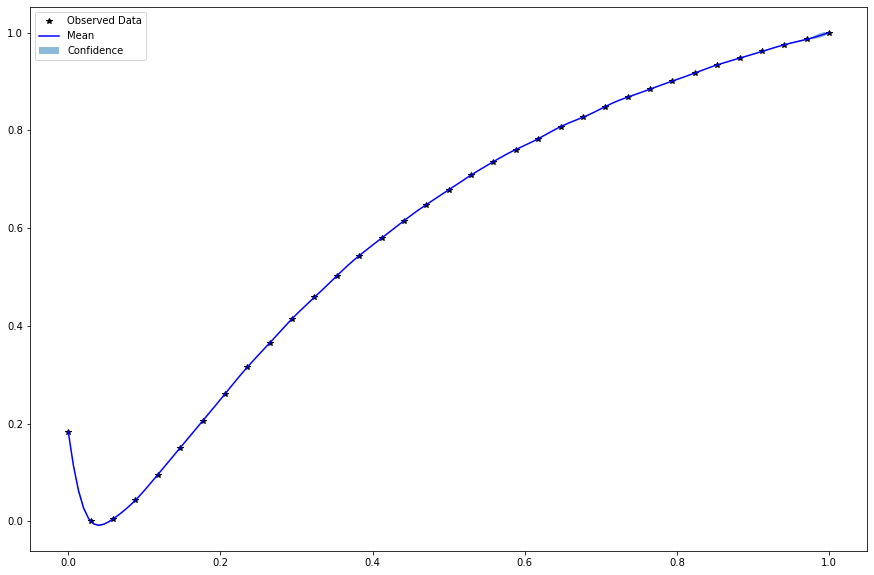

<Figure size 432x288 with 0 Axes>

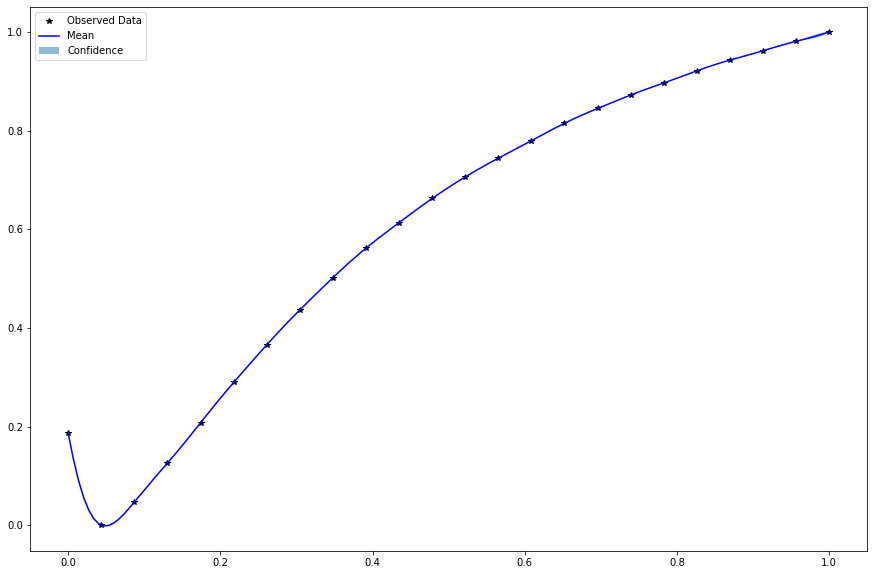

<Figure size 432x288 with 0 Axes>

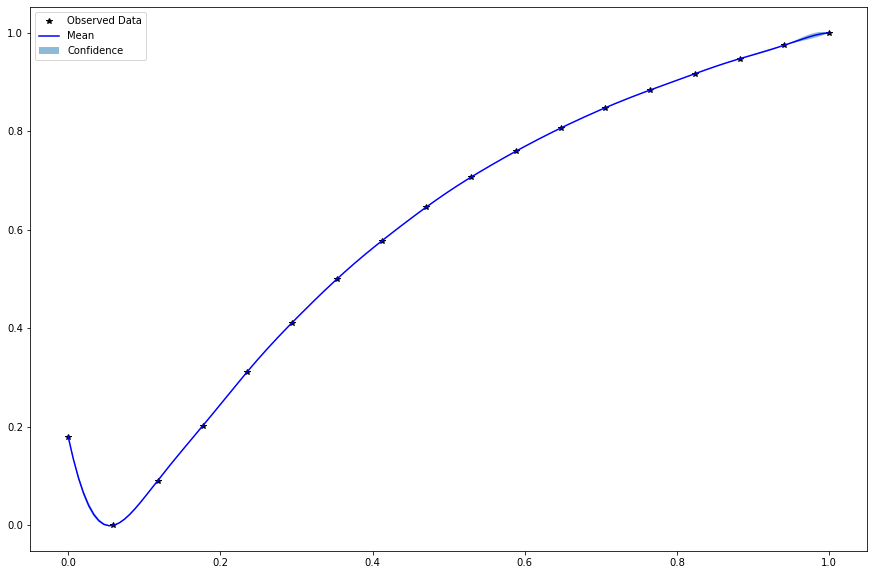

<Figure size 432x288 with 0 Axes>

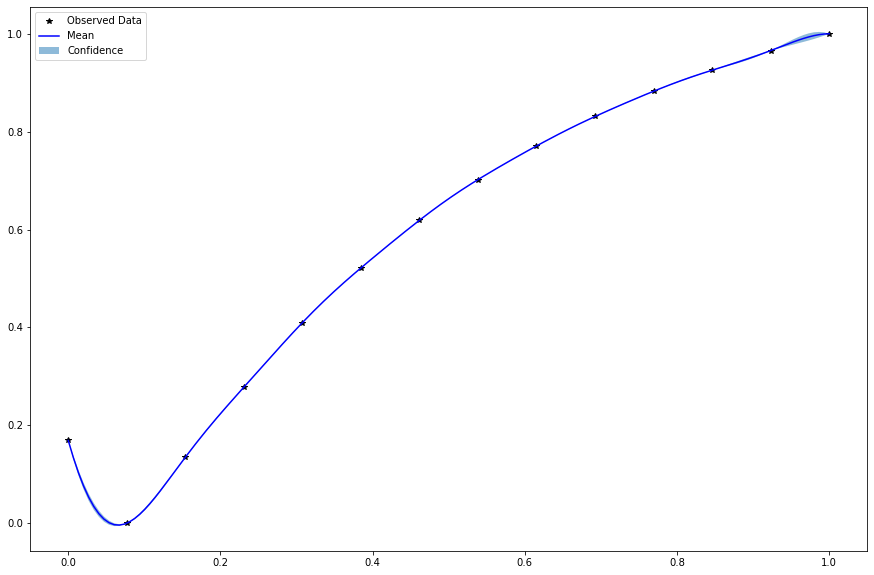

<Figure size 432x288 with 0 Axes>

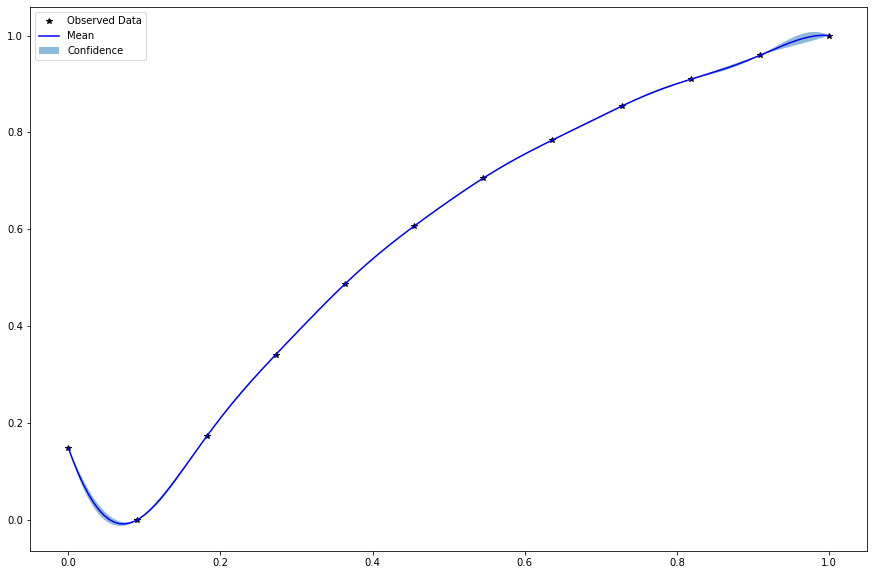

<Figure size 432x288 with 0 Axes>

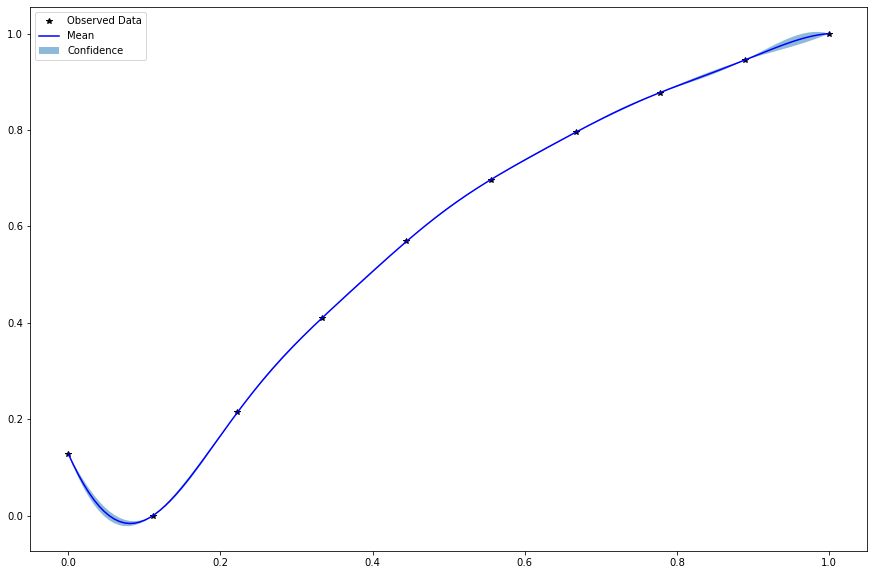

<Figure size 432x288 with 0 Axes>

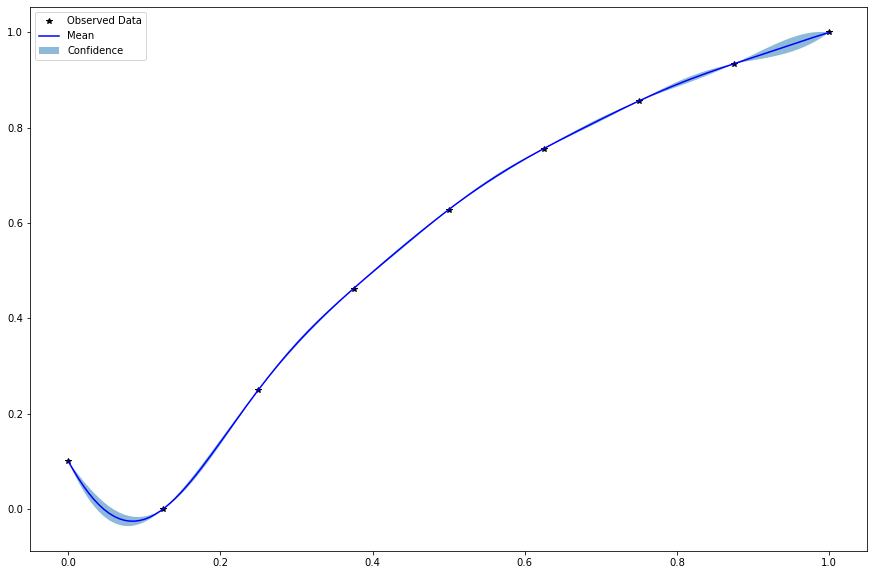

<Figure size 432x288 with 0 Axes>

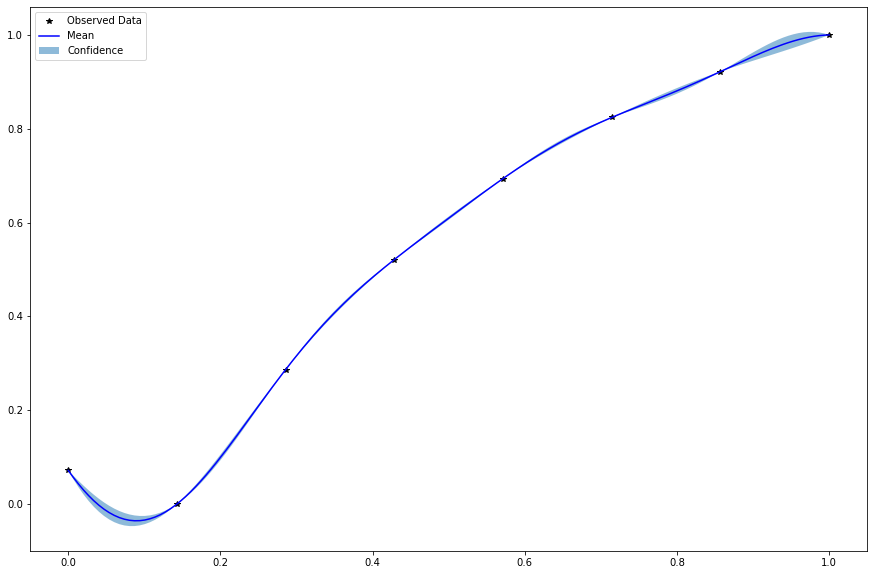

In [30]:
from sklearn.preprocessing import StandardScaler

test_x = np.linspace(0, 1, 150).reshape(-1, 1)

differentset = [temp_values]

for increment in range(2,10):
    local_temp_values = []
    for i in range(0,len(temp_values), increment):
        local_temp_values.append(temp_values[i])
    differentset.append(local_temp_values)


for local_temp_values in differentset:
    maxt = max(local_temp_values)
    mint = min(local_temp_values)

    for vibidx in range(len(vib_values)-1, len(vib_values)):
        train_x = []
        train_y = []

        maxy = float("-inf")
        miny = float("+inf")
    
        for idx, t in enumerate(local_temp_values):
            yval = df[t].values[vibidx]

            if yval < miny:
                miny = yval
            elif yval > maxy:
                maxy = yval

        for idx, t in enumerate(local_temp_values):
            tval = (t - mint)/(maxt - mint)
            train_x.append(tval)
        
            yval = df[t].values[vibidx]
            train_y.append((yval - miny)/(maxy - miny))
   
        minx = min(train_x)
        maxx = max(train_x)
        #print("Xval range: ", minx, maxx)
        #print("Yval range: ", min(train_y), max(train_y))

        train_x = np.asarray(train_x).reshape(-1, 1)
        train_y = np.asarray(train_y)

        model = None
        model = fitusingscikitl (train_x, train_y, minx, maxx)
        y_pred, std = model.predict(test_x, return_std=True)

        avgstdev = 0.0
        maxstd = float("-inf")
        lower = []
        upper = []
        for idx in range(len(y_pred)):
            val = 100.0 * (std[idx]/y_pred[idx])
            #print("%10.5e %10.5e %8.1f"%(y_pred[idx], std[idx], val))
            avgstdev += std[idx]
            if (std[idx] > maxstd):
                maxstd = std[idx]
            lower.append(y_pred[idx]-(2.0*std[idx]))
            upper.append(y_pred[idx]+(2.0*std[idx]))
    
        #print("Avg Stdev %10.5e"%(avgstdev/float(len(y_pred))) )
        #print("Max Stdev %10.5e"%(maxstd))

        plt.clf()
        f, ax = plt.subplots(1, 1, figsize=(4, 3))
        ax.plot(train_x, train_y, 'k*')
        ax.plot(test_x, y_pred, 'b')
        a = np.asarray(test_x).reshape(-1)
        b = np.asarray(lower)
        c = np.asarray(upper)
        ax.fill_between(a, b, c, alpha=0.5)
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
        plt.gcf().set_size_inches(15, 10)
        plt.show()